# Import the libraries

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertweetTokenizer, AutoModel, AutoTokenizer
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer

In [79]:
import warnings
warnings.filterwarnings("ignore")

In [80]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/hrz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Import the datasets

In [272]:
train = pd.read_csv('Datasets/train_text_emoji_clean.csv')
test = pd.read_csv('Datasets/test_text_emoji_clean.csv')
valid = pd.read_csv('Datasets/valid_text_emoji_clean.csv')

In [273]:
train.head()

,annotations,tweets,labels
0,😂,school is so dead o my god,0
1,😂,lol ive been told mine is worse than yours but...,0
2,😂,im excited to hear them that shit is going rat...,0
3,😂,damn alicia knows everything even indirect tweets,0
4,😂,that sound like everything,0


In [274]:
test.head()

,annotations,tweets,labels
0,😂,the conversation is so deep i saw adele rolling,0
1,😂,lord were coo as lol just waiting for break so...,0
2,😂,i cant,0
3,😂,these little kids talking about going to canad...,0
4,😂,only would do that,0


In [275]:
valid.head()

,annotations,tweets,labels
0,😂,hahaha you guys crack me up,0
1,😂,im dead,0
2,😂,ate girl the tweet was before tac pa,0
3,😂,also who wouldve thought that will griggs on f...,0
4,😂,im not fooling i you tonight,0


# Data cleaning

In [276]:
#emoji map
emoji = train['annotations'].unique()
emoji

array(['😂', '😭', '😍', '🙄', '❤', '😊', '😩', '🤔', '😘', '🏽', '💯', '🙃'],
      dtype=object)

In [277]:
def preprocess(message):
    message = re.sub(" +", " ", re.sub("\d+", " ", re.sub(r'[^\w\s]', '', message)))
    message = word_tokenize(message.lower())
    
    stop_words = set(stopwords.words('english'))
    message = [word for word in message if not word in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    message = [lemmatizer.lemmatize(word) for word in message]
    
    message = str(' '.join(message))
    return message

In [278]:
train['tweets'] = train['tweets'].apply(lambda x: preprocess(x))
test['tweets'] = test['tweets'].apply(lambda x: preprocess(x))
valid['tweets'] = valid['tweets'].apply(lambda x: preprocess(x))

In [279]:
train['tweets'].head(100)

0                                       school dead god
1                  lol ive told mine worse dont believe
2                im excited hear shit going rattle soul
3       damn alicia know everything even indirect tweet
4                                 sound like everything
                            ...                        
95    drunk guy bus compared rosa park kicked also a...
96                              beefing hoe cant relate
97                       im gon na make juan proud time
98    gram gave bottle white henne doesnt even fucki...
99    yall cant posting freaky stuff im scrolling ti...
Name: tweets, Length: 100, dtype: object

In [280]:
test['tweets'].head(100)

0                   conversation deep saw adele rolling
1                      lord coo lol waiting break chill
2                                                  cant
3     little kid talking going canada arent u like w...
4                                                 would
                            ...                        
95    yall nigga downgrading yall talk rat looking a...
96                                            bye bitch
97                 trending yung father day sa facebook
98                         ever thought something funny
99                                       broke as nigga
Name: tweets, Length: 100, dtype: object

In [281]:
valid['tweets'].head(100)

0                                      hahaha guy crack
1                                               im dead
2                                 ate girl tweet tac pa
3     also wouldve thought griggs fire would anthem ...
4                                    im fooling tonight
                            ...                        
95    yall ifs different boyfriendsgirlfriends every...
96    happyyyy birthday one fave gal know youll alwa...
97    whoever drunk elizabeth girl want liferelatiom...
98                                                might
99                                                 true
Name: tweets, Length: 100, dtype: object

In [282]:
train_X = train['tweets']
train_y = train['labels']
test_X = test['tweets']
test_y = test['labels']
valid_X = valid['tweets']
valid_y = valid['labels']

In [283]:
valid_y[0]

0

# Model

## Sklearn

In [93]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
tokenizer_sk = TfidfVectorizer(ngram_range=(1, 5), tokenizer=token.tokenize, norm="l2")
train_X_token = tokenizer_sk.fit_transform(train_X)
test_X_token = tokenizer_sk.transform(test_X)
valid_X_token = tokenizer_sk.transform(valid_X)

In [94]:
model_sk = [LogisticRegression(), SVC(), RandomForestClassifier()]
metrics = ['Accuracy', 'F1-score']

In [95]:
test_X_token.shape[0]

13485

Traing LogisticRegression() with TF-IDF
Traing SVC() with TF-IDF
Traing RandomForestClassifier() with TF-IDF


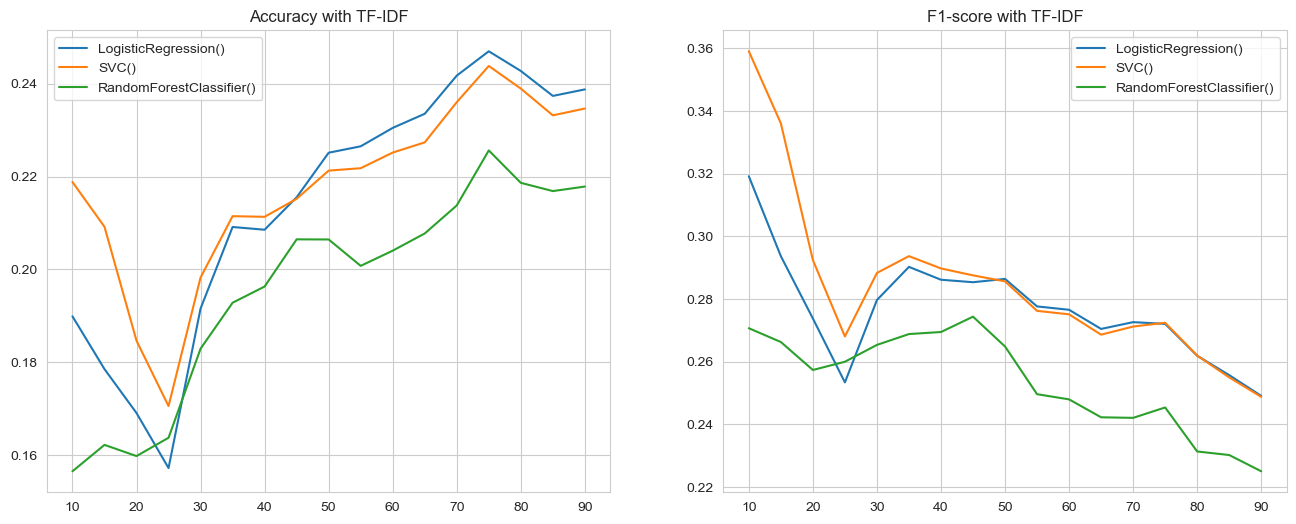

In [96]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
min, max = 10, 91
for i in range(2):
    ax[i].set_title(f'{metrics[i]} with TF-IDF')

for i in range(3):
    print(f'Traing {model_sk[i]} with TF-IDF')
    accuracy, f1 = [], []
    for j in range(min, max, 5):
        model_sk[i].fit(train_X_token, train_y)
        size = int(test_X_token.shape[0] * j / 100)
        test_X_token_ = test_X_token[:size]
        pred = model_sk[i].predict(test_X_token_)
        accuracy.append(accuracy_score(test_y[:size], pred))
        f1.append(f1_score(test_y[:size], pred, average='weighted'))
    ax[0].plot(range(min, max, 5), accuracy, label = f'{model_sk[i]}')
    ax[1].plot(range(min, max, 5), f1, label = f'{model_sk[i]}')
ax[0].legend()
ax[1].legend()
plt.show()
plt.savefig('Sklearn.png')

## LSTM

In [284]:
for i in range(train_X.shape[0]):
    train_X[i] = train_X[i].split()

for i in range(test_X.shape[0]):
    test_X[i] = test_X[i].split()

for i in range(valid_X.shape[0]):
    valid_X[i] = valid_X[i].split()

In [285]:
train_X.shape

(52884,)

In [292]:
for i in train_X[0]:
    print(i)

school
dead
god


In [166]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove*.zip

In [332]:
embeddings_index = {}

f = open('glove.twitter.27B.100d.txt', encoding = "utf8")
for line in f:
    w_values = line.split()
    word = w_values[0]
    embeddings_index[word] = np.asarray(w_values[1:], dtype='float32')
f.close()

In [333]:
embeddings_index['h'].shape

(100,)

In [361]:
matrix_train = np.zeros((train_X.shape[0], 34, 100))
matrix_test = np.zeros((test_X.shape[0], 34, 100))
matrix_valid = np.zeros((valid_X.shape[0], 34, 100))

for i in range(train_X.shape[0]):
    sum = 0
    for j in train_X[i]:     
        if (j in embeddings_index.keys()):
            matrix_train[i][sum] = embeddings_index[j]
        else:
            matrix_train[i][sum] = np.zeros(100)
        sum += 1

for i in range(test_X.shape[0]):
    sum = 0
    for j in test_X[i]:
        if (j in embeddings_index.keys()):
            matrix_test[i][sum] = embeddings_index[j]
        else:
            matrix_test[i][sum] = np.zeros(100)
        sum += 1

for i in range(valid_X.shape[0]):
    sum = 0
    for j in valid_X[i]:
        if (j in embeddings_index.keys()):
            matrix_valid[i][sum] = embeddings_index[j]
        else:
            matrix_valid[i][sum] = np.zeros(100)
        sum += 1

In [362]:
matrix_train.shape

(52884, 34, 100)

In [368]:
class Model(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_class):
        super(Model, self).__init__()
        self.lstm = nn.LSTM(in_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(2*hidden_dim, n_class)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = x.float()
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = x[:, -1]
        x = self.fc(x)
        #x = self.softmax(x)
        return x

In [381]:
model_lstm = Model(100, 17, 10)

In [370]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

In [371]:
best_acc = 0
patience = 0
count = 0

In [380]:
for epoch in range(10):
    model_lstm.train()
    for i in range(matrix_train.shape[0]):
        optimizer.zero_grad()
        output = model_lstm(torch.tensor(matrix_train[i]))
        loss = criterion(output, torch.tensor(train_y[i]))
        loss.backward()
        optimizer.step()
        if i % 10000 == 0:
            print(f'Epoch: {epoch+1}, Step: {i}, Loss: {loss.item()}')
    model_lstm.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(matrix_valid.shape[0]):
            output = model_lstm(torch.tensor(matrix_valid[i]))
            if (torch.argmax(output) - valid_y[i])<0.0001:
                correct += 1
            total += 1
    
    acc = correct / total
    print(f'Epoch: {epoch+1}, Validation Accuracy: {acc}')
    if acc > best_acc:
        best_acc = acc
        count = 0
    else:
        count += 1
        if count >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

Epoch: 1, Step: 0, Loss: 23.582626342773438
Epoch: 1, Step: 10000, Loss: 0.16758769750595093
Epoch: 1, Step: 20000, Loss: 2.145764938177308e-06
Epoch: 1, Step: 30000, Loss: 0.0010514690075069666
Epoch: 1, Step: 40000, Loss: 5.030505417380482e-05
Epoch: 1, Step: 50000, Loss: 0.00013493580627255142
Epoch: 1, Validation Accuracy: 0.042652622209034936
Epoch: 2, Step: 0, Loss: 16.38899040222168
Epoch: 2, Step: 10000, Loss: 0.005031067878007889
Epoch: 2, Step: 20000, Loss: 4.029192859889008e-05
Epoch: 2, Step: 30000, Loss: 0.0
Epoch: 2, Step: 40000, Loss: 0.4981456696987152
Epoch: 2, Step: 50000, Loss: 7.152555099310121e-07
Epoch: 2, Validation Accuracy: 0.042652622209034936
Early stopping at epoch 1
